#### Video basis: https://www.youtube.com/watch?v=qFJeN9V1ZsI
#### Blog basis: https://analyticsindiamag.com/hands-on-guide-to-implementing-alexnet-with-keras-for-multi-class-image-classification/

In [1]:
import itertools
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
phy_devices = tf.config.experimental.list_physical_devices('GPU')
print(phy_devices)
if phy_devices:
    tf.config.experimental.set_memory_growth(phy_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Dataset used: https://www.kaggle.com/code/profsoft/catsvsdogsclassificationwithcnn-attention

In [3]:
dataset_path = 'PetImages_2000-500-800'

train_path = f'data/{dataset_path}/training'
valid_path = f'data/{dataset_path}/validation'
test_path = f'data/{dataset_path}/testing'

per_batch_size = 30
num_epochs = 10
learn_rate = .001

class_names = ['cat', 'dog']
num_classes = len(class_names)

In [4]:
# preprocessing_function=tf.keras.applications.vgg16.preprocess_input
train_batch = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=class_names, batch_size=per_batch_size)
valid_batch = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=class_names, batch_size=per_batch_size)
test_batch = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=class_names, batch_size=per_batch_size, shuffle='False')

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


In [ ]:
assert train_batch.num_classes == valid_batch.num_classes == test_batch.num_classes == num_classes

In [ ]:
imgs, labels = next(train_batch)

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img/255)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
plotImages(imgs)

In [5]:
def create_AlexNet_model():
    model = Sequential()
    input_shape = (224, 224, 3)
    kernel_regularizer = 0.002

    #First block
    model.add(Conv2D(96, (11, 11), strides=(4,4),
            input_shape=input_shape, padding="same",
             kernel_regularizer=l2(kernel_regularizer)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=3, strides=2, padding="same"))
    model.add(BatchNormalization())

    #Second block
    model.add(Conv2D(256, (5, 5), padding="same",
                     kernel_regularizer=l2(kernel_regularizer)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    #Third block
    model.add(Conv2D(384, (3, 3), padding="same",
              kernel_regularizer=l2(kernel_regularizer)))
    model.add(Activation("relu"))
    model.add(BatchNormalization())

    #Fourth block
    model.add(Conv2D(384, (3, 3), padding="same",
                     kernel_regularizer=l2(kernel_regularizer)))
    model.add(Activation("relu"))
    model.add(BatchNormalization())

    #Fifth block
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1),
                     padding="same", kernel_regularizer=l2(kernel_regularizer)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
    model.add(BatchNormalization())

    #Fully connected blocks
    model.add(Flatten())
    
    #First FC block
    model.add(Dense(4096, kernel_regularizer=l2(kernel_regularizer)))
    model.add(Activation('relu'))
    #Add Dropout to prevent overfitting
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    #Second FC block
    model.add(Dense(4096, kernel_regularizer=l2(kernel_regularizer)))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(2, kernel_regularizer=l2(kernel_regularizer)))
    model.add(Activation('softmax'))

    # Instantiate a optimizer
    optimizer = Adam(learning_rate=learn_rate)

    # Instantiate a logistic loss function that expects integer targets.
    loss = categorical_crossentropy
    
    # Instantiate an accuracy metric.
    accuracy = 'accuracy'

    model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

    return model


def create_VGG16_model():
    # Transfer learning is applied here
    model = Sequential()
    
    vgg16_model = tf.keras.applications.vgg16.VGG16()
    for layer in vgg16_model.layers[:-1]:
        model.add(layer)
    
    for layer in model.layers:
        layer.trainable = False
    
    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    # Instantiate a optimizer
    optimizer = Adam(learning_rate=learn_rate)

    # Instantiate a logistic loss function that expects integer targets.
    loss = categorical_crossentropy
    
    # Instantiate an accuracy metric.
    accuracy = 'accuracy'

    model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

    return model


def create_YaNet_model():
    # Model I copy pasted from my friend
    model = Sequential()

    # 1st layer
    model.add(Conv2D(32,(3,3), activation = 'relu', input_shape = (224,224,3)))
    model.add(MaxPooling2D((2,2)))
    
    # 2nd layer
    model.add(Conv2D(32,(3,3), activation = 'relu'))
    model.add(MaxPooling2D((2,2)))

    model.add(Flatten()) # 3x3 to 9x1
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(2, activation = 'sigmoid'))
    
    # Instantiate a optimizer
    optimizer = Adam(learning_rate=learn_rate)

    # Instantiate a logistic loss function that expects integer targets.
    loss = categorical_crossentropy
    # loss = 'binary_crossentropy' was previous used
    
    # Instantiate an accuracy metric.
    accuracy = 'accuracy'
    
    model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])
    
    return model

In [ ]:
# AlexNet = create_AlexNet_model()

In [6]:
VGG16 = create_VGG16_model()

In [ ]:
# YaNet = create_YaNet_model()

In [ ]:
# AlexNet.fit(x=train_batch, validation_data=valid_batch, epochs=num_epochs, verbose=2)

In [7]:
VGG16.fit(x=train_batch, validation_data=valid_batch, epochs=num_epochs, verbose=2)

Epoch 1/10
134/134 - 56s - loss: 0.1505 - accuracy: 0.9452 - val_loss: 0.0548 - val_accuracy: 0.9840
Epoch 2/10
134/134 - 40s - loss: 0.0670 - accuracy: 0.9745 - val_loss: 0.0540 - val_accuracy: 0.9810
Epoch 3/10
134/134 - 40s - loss: 0.0386 - accuracy: 0.9850 - val_loss: 0.0488 - val_accuracy: 0.9830
Epoch 4/10
134/134 - 39s - loss: 0.0250 - accuracy: 0.9902 - val_loss: 0.0546 - val_accuracy: 0.9840
Epoch 5/10
134/134 - 39s - loss: 0.0156 - accuracy: 0.9952 - val_loss: 0.0567 - val_accuracy: 0.9840
Epoch 6/10
134/134 - 39s - loss: 0.0083 - accuracy: 0.9992 - val_loss: 0.0549 - val_accuracy: 0.9860
Epoch 7/10
134/134 - 40s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0541 - val_accuracy: 0.9870
Epoch 8/10
134/134 - 40s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0581 - val_accuracy: 0.9840
Epoch 9/10
134/134 - 40s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0572 - val_accuracy: 0.9860
Epoch 10/10
134/134 - 40s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0597 - val_accura

In [ ]:
# YaNet.fit(x=train_batch, validation_data=valid_batch, epochs=num_epochs, verbose=2)

In [ ]:
# AlexNet.evaluate(test_batch)

In [14]:
VGG16.evaluate(test_batch)

54/54 [==============================] - 12s 227ms/step - loss: 0.0807 - accuracy: 0.9837


[0.08066705614328384, 0.9837499856948853]

In [10]:
def plot_model(model):
    #Plotting the training and validation loss
    f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

    #Assigning the first subplot to graph training loss and validation loss
    ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
    ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

    #Plotting the training accuracy and validation accuracy
    ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
    ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

    plt.legend()
    
def predict_and_cm(prediction):
    #Plotting the confusion matrix
    conf_matrix = confusion_matrix(test_batch.classes,np.argmax(prediction, axis=-1))
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

In [11]:
# plot_model(AlexNet)

KeyError: 'loss'

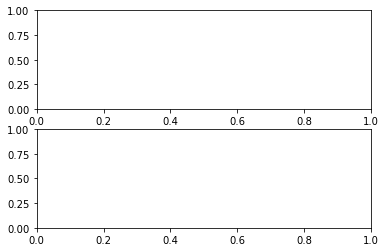

In [12]:
plot_model(VGG16)

In [ ]:
# plot_model(YaNet)

In [ ]:
# predict_and_cm(AlexNet.predict(x=test_batch, verbose=0))

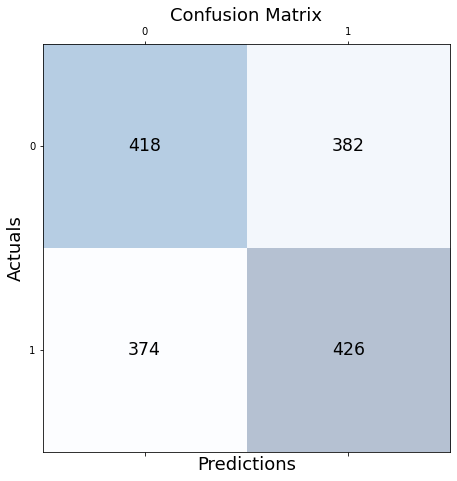

In [13]:
predict_and_cm(VGG16.predict(x=test_batch, verbose=0))

In [ ]:
# predict_and_cm(YaNet.predict(x=test_batch, verbose=0))